## Introduction to Linear Regression

We'll discuss one of the foundational algorithms in machine learning: *Linear regression*. We'll create a model that predicts crop yields for apples and oranges (*target variables*) by looking at the average temperature, rainfall, and humidity (*input variables or features*) in a region. Here's the training data:

![linear-regression-training-data](https://i.imgur.com/6Ujttb4.png)

In a linear regression model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

```
yield_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1
yield_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2
```

Visually, it means that the yield of apples is a linear or planar function of temperature, rainfall and humidity:

![linear-regression-graph](https://i.imgur.com/4DJ9f8X.png)

The *learning* part of linear regression is to figure out a set of weights `w11, w12,... w23, b1 & b2` using the training data, to make accurate predictions for new data. The _learned_ weights will be used to predict the yields for apples and oranges in a new region using the average temperature, rainfall, and humidity for that region.

We'll _train_ our model by adjusting the weights slightly many times to make better predictions, using an optimization technique called *gradient descent*. Let's begin by importing Numpy and PyTorch.

In [5]:
import numpy as np
import torch

## Training data

We can represent the training data using two matrices: `inputs` and `targets`, each with one row per observation, and one column per variable.

In [6]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

In [7]:
# Targets (apples, oranges)
targets = np.array([[56, 70],
                    [81, 101],
                    [119, 133],
                    [22, 37],
                    [103, 119]], dtype='float32')

We've separated the input and target variables because we'll operate on them separately. Also, we've created numpy arrays, because this is typically how you would work with training data: read some CSV files as numpy arrays, do some processing, and then convert them to PyTorch tensors.

Let's convert the arrays to PyTorch tensors.

In [8]:
# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


## Linear regression model from scratch

The weights and biases (`w11, w12,... w23, b1 & b2`) can also be represented as matrices, initialized as random values. The first row of `w` and the first element of `b` are used to predict the first target variable, i.e., yield of apples, and similarly, the second for oranges.

In [9]:
# Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)
print(w)
print(b)

tensor([[ 0.4235,  1.1407, -0.5949],
        [ 0.1516,  3.3284,  0.6250]], requires_grad=True)
tensor([ 0.9275, -1.1985], requires_grad=True)


`torch.randn` creates a tensor with the given shape, with elements picked randomly from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) with mean 0 and standard deviation 1.

Our *model* is simply a function that performs a matrix multiplication of the `inputs` and the weights `w` (transposed) and adds the bias `b` (replicated for each observation).

![matrix-mult](https://i.imgur.com/WGXLFvA.png)

We can define the model as follows:

In [11]:
def model(x):
    return x @ w.t() + b

`@` represents matrix multiplication in PyTorch, and the `.t` method returns the transpose of a tensor.

The matrix obtained by passing the input data into the model is a set of predictions for the target variables.

In [13]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[ 82.6904, 259.7457],
        [101.7753, 345.4958],
        [156.1240, 494.2439],
        [ 71.1643, 180.5118],
        [ 98.0144, 372.5372]], grad_fn=<AddBackward0>)


Let's compare the predictions of our model with the actual targets.

In [14]:
# Compare with targets
print(targets)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


You can see a big difference between our model's predictions and the actual targets because we've initialized our model with random weights and biases. Obviously, we can't expect a randomly initialized model to *just work*.

## Loss function

Before we improve our model, we need a way to evaluate how well our model is performing. We can compare the model's predictions with the actual targets using the following method:

* Calculate the difference between the two matrices (`preds` and `targets`).
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.

The result is a single number, known as the **mean squared error** (MSE).

In [15]:
# MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

`torch.sum` returns the sum of all the elements in a tensor. The `.numel` method of a tensor returns the number of elements in a tensor. Let's compute the mean squared error for the current predictions of our model.

In [16]:
# Compute loss
loss = mse(preds, targets)
print(loss)

tensor(31611.9648, grad_fn=<DivBackward0>)


Here’s how we can interpret the result: *On average, each element in the prediction differs from the actual target by the square root of the loss*. And that’s pretty bad, considering the numbers we are trying to predict are themselves in the range 50–200. The result is called the *loss* because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

## Compute gradients

With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases because they have `requires_grad` set to `True`. We'll see how this is useful in just a moment.

In [17]:
# Compute gradients
loss.backward()

The gradients are stored in the `.grad` property of the respective tensors. Note that the derivative of the loss w.r.t. the weights matrix is itself a matrix with the same dimensions.

In [18]:
# Gradients for weights
print(w)
print(w.grad)

tensor([[ 0.4235,  1.1407, -0.5949],
        [ 0.1516,  3.3284,  0.6250]], requires_grad=True)
tensor([[ 2347.8984,  2045.3093,  1220.1174],
        [19932.2070, 22629.1680, 13563.2959]])


## Adjust weights and biases to reduce the loss

The loss is a [quadratic function](https://en.wikipedia.org/wiki/Quadratic_function) of our weights and biases, and our objective is to find the set of weights where the loss is the lowest. If we plot a graph of the loss w.r.t any individual weight or bias element, it will look like the figure shown below. An important insight from calculus is that the gradient indicates the rate of change of the loss, i.e., the loss function's [slope](https://en.wikipedia.org/wiki/Slope) w.r.t. the weights and biases.

If a gradient element is **positive**:

* **increasing** the weight element's value slightly will **increase** the loss
* **decreasing** the weight element's value slightly will **decrease** the loss

![postive-gradient](https://i.imgur.com/WLzJ4xP.png)

If a gradient element is **negative**:

* **increasing** the weight element's value slightly will **decrease** the loss
* **decreasing** the weight element's value slightly will **increase** the loss

![negative=gradient](https://i.imgur.com/dvG2fxU.png)

The increase or decrease in the loss by changing a weight element is proportional to the gradient of the loss w.r.t. that element. This observation forms the basis of _the gradient descent_ optimization algorithm that we'll use to improve our model (by _descending_ along the _gradient_).

We can subtract from each weight element a small quantity proportional to the derivative of the loss w.r.t. that element to reduce the loss slightly.

In [19]:
w
w.grad

tensor([[ 2347.8984,  2045.3093,  1220.1174],
        [19932.2070, 22629.1680, 13563.2959]])

In [20]:
with torch.no_grad():
    print(w.grad * 1e-5)

tensor([[0.0235, 0.0205, 0.0122],
        [0.1993, 0.2263, 0.1356]])


In [21]:
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5

We multiply the gradients with a very small number (`10^-5` in this case) to ensure that we don't modify the weights by a very large amount. We want to take a small step in the downhill direction of the gradient, not a giant leap. This number is called the *learning rate* of the algorithm.

We use `torch.no_grad` to indicate to PyTorch that we shouldn't track, calculate, or modify gradients while updating the weights and biases.

In [22]:
# Let's verify that the loss is actually lower
loss = mse(preds, targets)
print(loss)

tensor(31611.9648, grad_fn=<DivBackward0>)


Before we proceed, we reset the gradients to zero by invoking the `.zero_()` method. We need to do this because PyTorch accumulates gradients. Otherwise, the next time we invoke `.backward` on the loss, the new gradient values are added to the existing gradients, which may lead to unexpected results.

In [23]:
w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


## Train the model using gradient descent

As seen above, we reduce the loss and improve our model using the gradient descent optimization algorithm. Thus, we can _train_ the model using the following steps:

1. Generate predictions

2. Calculate the loss

3. Compute gradients w.r.t the weights and biases

4. Adjust the weights by subtracting a small quantity proportional to the gradient

5. Reset the gradients to zero

Let's implement the above step by step.

In [24]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[ 79.0811, 224.1990],
        [ 97.0578, 298.7609],
        [150.6326, 438.7107],
        [ 67.4383, 145.4296],
        [ 93.5765, 327.5633]], grad_fn=<AddBackward0>)


In [25]:
# Calculate the loss
loss = mse(preds, targets)
print(loss)

tensor(21554.6035, grad_fn=<DivBackward0>)


In [26]:
# Compute gradients
loss.backward()
print(w.grad)
print(b.grad)

tensor([[ 1976.5405,  1649.4971,   975.2904],
        [16260.0566, 18676.8164, 11125.9609]])
tensor([ 21.3573, 194.9327])


Let's update the weights and biases using the gradients computed above.

In [27]:
# Adjust weights & reset gradients
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

Let's take a look at the new weights and biases.

In [28]:
print(w)
print(b)

tensor([[ 0.3803,  1.1038, -0.6169],
        [-0.2103,  2.9153,  0.3781]], requires_grad=True)
tensor([ 0.9270, -1.2029], requires_grad=True)


With the new weights and biases, the model should have a lower loss.

In [29]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(14774.5137, grad_fn=<DivBackward0>)


We have already achieved a significant reduction in the loss merely by adjusting the weights and biases slightly using gradient descent.

## Train for multiple epochs

To reduce the loss further, we can repeat the process of adjusting the weights and biases using the gradients multiple times. Each iteration is called an _epoch_. Let's train the model for 100 epochs.

In [30]:
# Train for 100 epochs
for i in range(1000):
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

Once again, let's verify that the loss is now lower:

In [31]:
# Calculate loss\
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(27.0870, grad_fn=<DivBackward0>)


The loss is now much lower than its initial value. Let's look at the model's predictions and compare them with the targets.

In [32]:
# Predictions
preds

tensor([[ 57.7881,  70.4952],
        [ 78.2481,  97.3828],
        [126.6982, 140.1320],
        [ 23.3602,  38.9220],
        [ 93.8863, 112.0691]], grad_fn=<AddBackward0>)

In [33]:
# Targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

The predictions are now quite close to the target variables. We can get even better results by training for a few more epochs.

## Linear regression using PyTorch built-ins

We've implemented linear regression & gradient descent model using some basic tensor operations. However, since this is a common pattern in deep learning, PyTorch provides several built-in functions and classes to make it easy to create and train models with just a few lines of code.

Let's begin by importing the `torch.nn` package from PyTorch, which contains utility classes for building neural networks.

In [34]:
import torch.nn as nn

As before, we represent the inputs and targets and matrices.

In [35]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [74, 66, 43],
                   [91, 87, 65],
                   [88, 134, 59],
                   [101, 44, 37],
                   [68, 96, 71],
                   [73, 66, 44],
                   [92, 87, 64],
                   [87, 135, 57],
                   [103, 43, 36],
                   [68, 97, 70]],
                  dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70],
                    [81, 101],
                    [119, 133],
                    [22, 37],
                    [103, 119],
                    [57, 69],
                    [80, 102],
                    [118, 132],
                    [21, 38],
                    [104, 118],
                    [57, 69],
                    [82, 100],
                    [118, 134],
                    [20, 38],
                    [102, 120]],
                   dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [49]:
inputs

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.],
        [ 74.,  66.,  43.],
        [ 91.,  87.,  65.],
        [ 88., 134.,  59.],
        [101.,  44.,  37.],
        [ 68.,  96.,  71.],
        [ 73.,  66.,  44.],
        [ 92.,  87.,  64.],
        [ 87., 135.,  57.],
        [103.,  43.,  36.],
        [ 68.,  97.,  70.]])

We are using 15 training examples to illustrate how to work with large datasets in small batches.

## Dataset and DataLoader

We'll create a `TensorDataset`, which allows access to rows from `inputs` and `targets` as tuples, and provides standard APIs for working with many different types of datasets in PyTorch.

In [38]:
from torch.utils.data import TensorDataset

In [41]:
# Define dataset
train_ds = TensorDataset(inputs, targets)
train_ds[0:5]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.],
         [102.,  43.,  37.],
         [ 69.,  96.,  70.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.],
         [ 22.,  37.],
         [103., 119.]]))

The `TensorDataset` allows us to access a small section of the training data using the array indexing notation (`[0:3]` in the above code). It returns a tuple with two elements. The first element contains the input variables for the selected rows, and the second contains the targets.

We'll also create a `DataLoader`, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data.

In [42]:
from torch.utils.data import DataLoader

In [44]:
# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

We can use the data loader in a `for` loop. Let's look at an example.

In [50]:
for xb, yb in train_dl:
    print(xb)
    print(yb)
    break

tensor([[ 91.,  88.,  64.],
        [ 68.,  96.,  71.],
        [ 73.,  67.,  43.],
        [ 87., 134.,  58.],
        [ 73.,  66.,  44.]])
tensor([[ 81., 101.],
        [104., 118.],
        [ 56.,  70.],
        [119., 133.],
        [ 57.,  69.]])


In each iteration, the data loader returns one batch of data with the given batch size. If `shuffle` is set to `True`, it shuffles the training data before creating batches. Shuffling helps randomize the input to the optimization algorithm, leading to a faster reduction in the loss.

## nn.Linear

Instead of initializing the weights & biases manually, we can define the model using the `nn.Linear` class from PyTorch, which does it automatically.

In [81]:
import torch.nn.functional as F

class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

PyTorch models also have a helpful `.parameters` method, which returns a list containing all the weights and bias matrices present in the model. For our linear regression model, we have one weight matrix and one bias matrix.

In [82]:
# print model parameters
model = model()
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.2845,  0.5271, -0.4577],
        [-0.4295,  0.3285, -0.5256],
        [-0.0718, -0.5395, -0.3819],
        [ 0.3263, -0.1759, -0.0452],
        [ 0.4679, -0.1139, -0.2437],
        [ 0.2254, -0.3543,  0.0331],
        [-0.5229,  0.1676, -0.0746],
        [ 0.1277, -0.2543,  0.1494],
        [-0.2638,  0.1279, -0.0881],
        [-0.0479, -0.0411,  0.0291]], requires_grad=True), Parameter containing:
tensor([-0.4768, -0.4559,  0.1452,  0.3166, -0.4069, -0.1446,  0.1624,  0.5201,
        -0.4959, -0.2158], requires_grad=True), Parameter containing:
tensor([[ 0.0535,  0.2362, -0.1241,  0.2771,  0.1747, -0.1450,  0.2725,  0.2899,
          0.2632, -0.1076],
        [-0.2004,  0.0965,  0.0552, -0.2199, -0.1658,  0.1183,  0.1908,  0.0100,
         -0.1836, -0.2960],
        [ 0.1226,  0.0730,  0.1576,  0.1062,  0.0963, -0.2244,  0.1850,  0.0462,
         -0.2924,  0.0517],
        [ 0.2609, -0.2671, -0.2866,  0.0853, -0.0825,  0.1448,  0.0288, -0.0850,
     

We can use the model to generate predictions in the same way as before.

In [83]:
# Generate predictions
preds = model(inputs)
preds

tensor([[-0.4317,  1.7060],
        [-0.4612,  1.8630],
        [ 0.0831,  0.6587],
        [-0.1268,  3.8611],
        [-0.2820,  0.2131],
        [-0.4429,  1.7875],
        [-0.4653,  1.8608],
        [ 0.0560,  0.6567],
        [-0.1399,  3.8072],
        [-0.2756,  0.1284],
        [-0.4358,  1.7039],
        [-0.4724,  1.9445],
        [ 0.1084,  0.6829],
        [-0.1246,  3.9326],
        [-0.2720,  0.1298]], grad_fn=<AddmmBackward0>)

## Loss Function

Instead of defining a loss function manually, we can use the built-in loss function `mse_loss`.

In [84]:
# Import nn.functional
import torch.nn.functional as F

The `nn.functional` package contains many useful loss functions and several other utilities.

In [85]:
# Define loss function
loss_fn = F.mse_loss

Let's compute the loss for the current predictions of our model.

In [86]:
loss = loss_fn(model(inputs), targets)
print(loss)

tensor(8216.9414, grad_fn=<MseLossBackward0>)


## Optimizer

Instead of manually manipulating the model's weights & biases using gradients, we can use the optimizer `optim.SGD`. SGD is short for "stochastic gradient descent". The term _stochastic_ indicates that samples are selected in random batches instead of as a single group.

In [87]:
# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

Note that `model.parameters()` is passed as an argument to `optim.SGD` so that the optimizer knows which matrices should be modified during the update step. Also, we can specify a learning rate that controls the amount by which the parameters are modified.

## Train the model

We are now ready to train the model. We'll follow the same process to implement gradient descent:

1. Generate predictions

2. Calculate the loss

3. Compute gradients w.r.t the weights and biases

4. Adjust the weights by subtracting a small quantity proportional to the gradient

5. Reset the gradients to zero

The only change is that we'll work batches of data instead of processing the entire training data in every iteration. Let's define a utility function `fit` that trains the model for a given number of epochs.

In [88]:
# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl):

    # Repeat for given number of epochs
    for epoch in range(num_epochs):

        # Train with batches of data
        for xb,yb in train_dl:

            # 1. Generate predictions
            pred = model(xb)

            # 2. Calculate loss
            loss = loss_fn(pred, yb)

            # 3. Compute gradients
            loss.backward()

            # 4. Update parameters using gradients
            opt.step()

            # 5. Reset the gradients to zero
            opt.zero_grad()

        # Print the progress
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Some things to note above:

* We use the data loader defined earlier to get batches of data for every iteration.

* Instead of updating parameters (weights and biases) manually, we use `opt.step` to perform the update and `opt.zero_grad` to reset the gradients to zero.

* We've also added a log statement that prints the loss from the last batch of data for every 10th epoch to track training progress. `loss.item` returns the actual value stored in the loss tensor.

Let's train the model for 100 epochs.

In [89]:
fit(100, model, loss_fn, opt, train_dl)

Epoch [10/100], Loss: 926.5201
Epoch [20/100], Loss: 191.7068
Epoch [30/100], Loss: 502.7209
Epoch [40/100], Loss: 246.5168
Epoch [50/100], Loss: 202.5840
Epoch [60/100], Loss: 47.4743
Epoch [70/100], Loss: 62.8889
Epoch [80/100], Loss: 42.4367
Epoch [90/100], Loss: 57.2819
Epoch [100/100], Loss: 50.1410


Let's generate predictions using our model and verify that they're close to our targets.

In [61]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 58.0146,  72.3033],
        [ 80.8666,  98.2408],
        [119.2223, 135.2190],
        [ 27.0748,  48.8244],
        [ 96.1068, 107.9120],
        [ 56.8889,  71.4289],
        [ 80.4373,  97.7852],
        [119.4050, 135.5972],
        [ 28.2006,  49.6988],
        [ 96.8033, 108.3308],
        [ 57.5854,  71.8477],
        [ 79.7408,  97.3663],
        [119.6516, 135.6746],
        [ 26.3783,  48.4055],
        [ 97.2326, 108.7864]], grad_fn=<AddmmBackward0>)

In [62]:
# Compare with targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 57.,  69.],
        [ 80., 102.],
        [118., 132.],
        [ 21.,  38.],
        [104., 118.],
        [ 57.,  69.],
        [ 82., 100.],
        [118., 134.],
        [ 20.,  38.],
        [102., 120.]])

Indeed, the predictions are quite close to our targets. We have a trained a reasonably good model to predict crop yields for apples and oranges by looking at the average temperature, rainfall, and humidity in a region. We can use it to make predictions of crop yields for new regions by passing a batch containing a single row of input.

In [ ]:
model(torch.tensor([[75, 63, 44.]]))

tensor([[53.2567, 69.0241]], grad_fn=<AddmmBackward>)

The predicted yield of apples is 54.3 tons per hectare, and that of oranges is 68.3 tons per hectare.

## Machine Learning vs. Classical Programming

The approach we've taken in this tutorial is very different from programming as you might know it. Usually, we write programs that take some inputs, perform some operations, and return a result.

However, in this notebook, we've defined a "model" that assumes a specific relationship between the inputs and the outputs, expressed using some unknown parameters (weights & biases). We then show the model some know inputs and outputs and _train_ the model to come up with good values for the unknown parameters. Once trained, the model can be used to compute the outputs for new inputs.

This paradigm of programming is known as _machine learning_, where we use data to figure out the relationship between inputs and outputs. _Deep learning_ is a branch of machine learning that uses matrix operations, non-linear activation functions and gradient descent to build and train models. Andrej Karpathy, the director of AI at Tesla Motors, has written a great blog post on this topics, titled [Software 2.0](https://medium.com/@karpathy/software-2-0-a64152b37c35).

This picture from book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by Francois Chollet captures the difference between classical programming and machine learning:

![](https://i.imgur.com/oJEQe7k.png)

Keep this picture in mind as you work through the next few tutorials.



## Exercises and Further Reading

We've covered the following topics in this tutorial:

- Introduction to linear regression and gradient descent
- Implementing a linear regression model using PyTorch tensors
- Training a linear regression model using the gradient descent algorithm
- Implementing gradient descent and linear regression using PyTorch built-in


Here are some resources for learning more about linear regression and gradient descent:

* An visual & animated explanation of gradient descent: https://www.youtube.com/watch?v=IHZwWFHWa-w

* For a more detailed explanation of derivates and gradient descent, see [these notes from a Udacity course](https://storage.googleapis.com/supplemental_media/udacityu/315142919/Gradient%20Descent.pdf).

* For an animated visualization of how linear regression works, [see this post](https://hackernoon.com/visualizing-linear-regression-with-pytorch-9261f49edb09).

* For a more mathematical treatment of matrix calculus, linear regression and gradient descent, you should check out [Andrew Ng's excellent course notes](https://github.com/Cleo-Stanford-CS/CS229_Notes/blob/master/lectures/cs229-notes1.pdf) from CS229 at Stanford University.

* To practice and test your skills, you can participate in the [Boston Housing Price Prediction](https://www.kaggle.com/c/boston-housing) competition on Kaggle, a website that hosts data science competitions.

With this, we complete our discussion of linear regression in PyTorch, and we’re ready to move on to the next topic: [Working with Images & Logistic Regression](https://jovian.ai/aakashns/03-logistic-regression).

## Questions for Review

Try answering the following questions to test your understanding of the topics covered in this notebook:

1. What is a linear regression model? Give an example of a problem formulated as a linear regression model.
2. What are input and target variables in a dataset? Give an example.
3. What are weights and biases in a linear regression model?
4. How do you represent tabular data using PyTorch tensors?
5. Why do we create separate matrices for inputs and targets while training a linear regression model?
6. How do you determine the shape of the weights matrix & bias vector given some training data?
7. How do you create randomly initialized weights & biases with a given shape?
8. How is a linear regression model implemented using matrix operations? Explain with an example.
9. How do you generate predictions using a linear regression model?
10. Why are the predictions of a randomly initialized model different from the actual targets?
11. What is a loss function? What does the term “loss” signify?
12. What is mean squared error?
13. Write a function to calculate mean squared using model predictions and actual targets.
14. What happens when you invoke the `.backward` function on the result of the mean squared error loss function?
15. Why is the derivative of the loss w.r.t. the weights matrix itself a matrix? What do its elements represent?
16. How is the derivate of the loss w.r.t. a weight element useful for reducing the loss? Explain with an example.
17. Suppose the derivative  of the loss w.r.t. a weight element is positive. Should you increase or decrease the element’s value slightly to get a lower loss?
18. Suppose the derivative  of the loss w.r.t. a weight element is negative. Should you increase or decrease the element’s value slightly to get a lower loss?
19. How do you update the weights and biases of a model using their respective gradients to reduce the loss slightly?
20. What is the gradient descent optimization algorithm? Why is it called “gradient descent”?
21. Why do you subtract a “small quantity” proportional to the gradient from the weights & biases, not the actual gradient itself?
22. What is learning rate? Why is it important?
23. What is `torch.no_grad`?
24. Why do you reset gradients to zero after updating weights and biases?
25. What are the steps involved in training a linear regression model using gradient descent?
26. What is an epoch?
27. What is the benefit of training a model for multiple epochs?
28. How do you make predictions using a trained model?
29. What should you do if your model’s loss doesn’t decrease while training? Hint: learning rate.
30. What is `torch.nn`?
31. What is the purpose of the `TensorDataset` class in PyTorch? Give an example.
32. What is a data loader in PyTorch? Give an example.
33. How do you use a data loader to retrieve batches of data?
34. What are the benefits of shuffling the training data before creating batches?
35. What is the benefit of training in small batches instead of training with the entire dataset?
36. What is the purpose of the `nn.Linear` class in PyTorch? Give an example.
37. How do you see the weights and biases of a `nn.Linear` model?
38. What is the purpose of the `torch.nn.functional` module?
39. How do you compute mean squared error loss using a PyTorch built-in function?
40. What is an optimizer in PyTorch?
41. What is `torch.optim.SGD`? What does SGD stand for?
42. What are the inputs to a PyTorch optimizer?
43. Give an example of creating an optimizer for training a linear regression model.
44. Write a function to train a `nn.Linear` model in batches using gradient descent.
45. How do you use a linear regression model to make predictions on previously unseen data?



# Working with images
## Convolutional neural nets

In [90]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [93]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


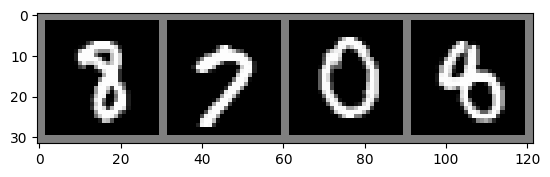

    8     7     0     8


In [94]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize, since we normalized the images when loading
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Grab some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(4)))

In [95]:
# define a linear layer neural net with three layers and relu functions and log softmax function at the end
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [96]:
# train the Net using SGD and optimise cross entropy losss
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# train the network for 2 epochs

for epoch in range(2):
    # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 0.813
[1,  4000] loss: 0.373
[1,  6000] loss: 0.328
[1,  8000] loss: 0.277
[1, 10000] loss: 0.261
[1, 12000] loss: 0.229
[1, 14000] loss: 0.209
[2,  2000] loss: 0.180
[2,  4000] loss: 0.162
[2,  6000] loss: 0.172
[2,  8000] loss: 0.163
[2, 10000] loss: 0.165
[2, 12000] loss: 0.148
[2, 14000] loss: 0.154
